### Merged Exoplanet Dataset
I will attempt to create a joint dataset for exoplanet detection comprising the data from Kepler, TESS and K2 dataset. Its varying features and ids constitute primary challenge here. I will join via shared columns.

In [39]:
import pandas as pd 

kepler = pd.read_csv('datasets/KOI.csv', comment='#')
tess = pd.read_csv('datasets/TOI.csv', comment='#')
k2 = pd.read_csv('datasets/K2P.csv', comment='#')

We'll create a joint table with common features.


In [40]:
import numpy as np

kepler_map = {
    "koi_period": "period_d",
    "koi_prad": "rp_re",
    "koi_insol": "insol_eflux",
    "koi_steff": "teff_k",
    "koi_slogg": "logg_cgs",
    "koi_srad": "rstar_rsun",
    "koi_kepmag": "mag_mission",
    "ra": "ra_deg",
    "dec": "dec_deg",
}

tess_map = {
    "pl_orbper": "period_d",
    "pl_rade": "rp_re",
    "pl_insol": "insol_eflux",
    "st_teff": "teff_k",
    "st_logg": "logg_cgs",
    "st_rad": "rstar_rsun",
    "st_tmag": "mag_mission",
    "ra": "ra_deg",
    "dec": "dec_deg",
}

k2_map = {
    "pl_orbper": "period_d",
    "pl_rade": "rp_re",
    "pl_insol": "insol_eflux",
    "st_teff": "teff_k",
    "st_logg": "logg_cgs",
    "st_rad": "rstar_rsun",
    "sy_gaiamag": "mag_mission",  
    "ra": "ra_deg",
    "dec": "dec_deg",
}

def map_label_kepler(s):
    s = str(s).strip().upper()
    if s == "CONFIRMED": return 1
    if s == "FALSE POSITIVE": return 0
    return np.nan  

def map_label_tess(s):
    s = str(s).strip().upper()
    if s in ("CP", "KP"): return 1
    if s == "FP": return 0
    return np.nan

def map_label_k2(s):
    s = str(s).strip().upper()
    if s == "CONFIRMED": return 1
    if s == "FALSE POSITIVE": return 0
    return np.nan

def harmonize(df, cmap, mission, label_col, label_func):
    d = df.rename(columns=cmap).copy()
    d["mission"] = mission
    d["label"] = d[label_col].map(label_func)
    # build star_key (≈1″ bins)
    d["star_key"] = d["ra_deg"].round(5).astype(str) + "_" + d["dec_deg"].round(5).astype(str)
    return d

k_kepler = harmonize(kepler, kepler_map, "KEPLER", "koi_disposition", map_label_kepler)
k_tess = harmonize(tess, tess_map, "TESS", "tfopwg_disp", map_label_tess)
k_k2 = harmonize(k2, k2_map, "K2", "disposition", map_label_k2)

strict_cols = [
    "period_d","rp_re","insol_eflux","teff_k","logg_cgs","rstar_rsun",
    "mag_mission","ra_deg","dec_deg","mission","label","star_key"
] 

kepler_u = k_kepler[[c for c in strict_cols if c in k_kepler.columns]]
tess_u = k_tess[[c for c in strict_cols if c in k_tess.columns]]
k2_u = k_k2[[c for c in strict_cols if c in k_k2.columns]]

all_u = pd.concat([kepler_u, tess_u, k2_u], ignore_index=True)

all_u = all_u.dropna(subset=["label"]).copy()
all_u = all_u.drop_duplicates(subset=[c for c in strict_cols if c in all_u.columns])

feat_cols = [
    "period_d","rp_re","insol_eflux","teff_k","logg_cgs","rstar_rsun",
    # use standardized mag?
    # you may drop ra/dec from X and keep only for star_key if you prefer
    # "ra_deg","dec_deg",
    "mission"           # one-hot later
]
groups_all = all_u["star_key"]
num_cols = ["period_d", "rp_re", "insol_eflux", "teff_k", "logg_cgs", "rstar_rsun", "mag_mission", "ra_deg", "dec_deg"]
cat_cols = ["mission"]

all_u

,period_d,rp_re,insol_eflux,teff_k,logg_cgs,rstar_rsun,mag_mission,ra_deg,dec_deg,mission,label,star_key
0,9.488036,2.26000,93.5900,5455.0,4.46700,0.927000,15.34700,291.934230,48.141651,KEPLER,1.0,291.93423_48.14165
1,54.418383,2.83000,9.1100,5455.0,4.46700,0.927000,15.34700,291.934230,48.141651,KEPLER,1.0,291.93423_48.14165
3,1.736952,33.46000,891.9600,5805.0,4.56400,0.791000,15.59700,285.534610,48.285210,KEPLER,0.0,285.53461_48.28521
4,2.525592,2.75000,926.1600,6031.0,4.43800,1.046000,15.50900,288.754880,48.226200,KEPLER,1.0,288.75488_48.2262
5,11.094321,3.90000,114.8100,6046.0,4.48600,0.972000,15.71400,296.286130,48.224670,KEPLER,1.0,296.28613_48.22467
...,...,...,...,...,...,...,...,...,...,...,...,...
21211,2.484197,NaN,NaN,NaN,NaN,NaN,11.33470,342.385899,-10.675469,K2,1.0,342.3859_-10.67547
21220,6.001180,2.03000,69.6000,4716.0,4.62000,0.690000,9.89816,206.846198,-6.139337,K2,1.0,206.8462_-6.13934
21221,6.001270,2.04300,NaN,4716.0,4.62000,0.689000,9.89816,206.846198,-6.139337,K2,1.0,206.8462_-6.13934
21222,NaN,1.75752,12.6807,4759.0,4.70975,0.641805,9.89816,206.846198,-6.139337,K2,1.0,206.8462_-6.13934


In [41]:
all_u.isnull().sum() / all_u.shape[0]

period_d       0.003979
rp_re          0.073287
insol_eflux    0.179438
teff_k         0.063818
logg_cgs       0.105117
rstar_rsun     0.036763
mag_mission    0.001591
ra_deg         0.000080
dec_deg        0.000080
mission        0.000000
label          0.000000
star_key       0.000000
dtype: float64

In [42]:
X = all_u[cat_cols + num_cols]
y = all_u["label"].astype('int')

In [43]:
from sklearn.model_selection import GroupShuffleSplit 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold, GridSearchCV

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups_all))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train = groups_all.iloc[train_idx]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop"
)

pipeline = Pipeline([
    ("preprocessing", preprocess),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs"))
])

C_l2 = np.logspace(-3, 3, 7)                 # 1e-3 … 1e3
C_l1 = [1e-3, 1e-2, 1e-1, 1, 10, 100]        # smaller cap for L1/EN

param_grid = [
    {
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs"],
        "clf__C": C_l2,
        "clf__class_weight": [None, "balanced"],
        "clf__max_iter": [3000],
        "clf__tol": [1e-4, 1e-3],
    },
    {
        "clf__penalty": ["l1"],
        "clf__solver": ["liblinear"],
        "clf__C": C_l1,
        "clf__class_weight": [None, "balanced"],
        "clf__max_iter": [5000],
        "clf__tol": [1e-3],   
    },
    {
        "clf__penalty": ["elasticnet"],
        "clf__solver": ["saga"],
        "clf__l1_ratio": [0.1, 0.5, 0.9],
        "clf__C": [0.1, 1, 10],
        "clf__class_weight": [None, "balanced"],
        "clf__max_iter": [5000],
        "clf__tol": [1e-3],
    },
]

kf = GroupKFold(n_splits=5)
log_reg_cv = GridSearchCV(pipeline, param_grid=param_grid, scoring="average_precision", cv=kf, n_jobs=-1, refit=True, verbose=1)
log_reg_cv.fit(X_train, y_train, groups=groups_train)

log_reg_best_model = log_reg_cv.best_estimator_ 
print("Best PR-AUC:", log_reg_cv.best_score_)
print("Best params:", log_reg_cv.best_params_)

Fitting 5 folds for each of 58 candidates, totalling 290 fits
Best PR-AUC: 0.8829412203489765
Best params: {'clf__C': np.float64(1000.0), 'clf__class_weight': None, 'clf__max_iter': 3000, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'clf__tol': 0.001}


In [44]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = log_reg_best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.74      0.80      1273
           1       0.77      0.89      0.82      1221

    accuracy                           0.81      2494
   macro avg       0.82      0.82      0.81      2494
weighted avg       0.82      0.81      0.81      2494

[[ 946  327]
 [ 138 1083]]


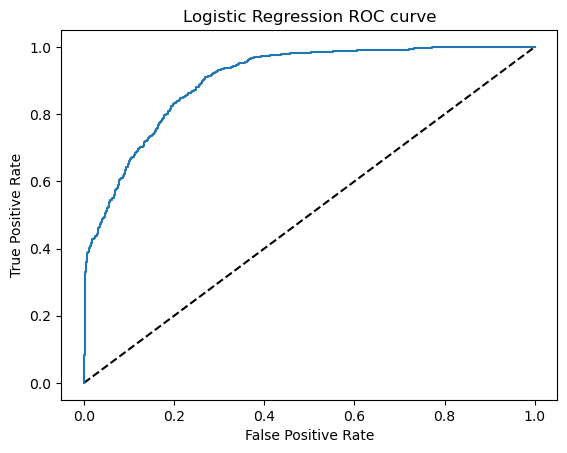

ROC-AUC score: 0.9030407255073397
Test PR-AUC (AP): 0.8971398949239325


In [45]:
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
y_pred_probabilities = log_reg_best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_probabilities)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC curve")
plt.show()
print("ROC-AUC score:", roc_auc_score(y_test, y_pred_probabilities))
print("Test PR-AUC (AP):", average_precision_score(y_test, y_pred_probabilities))

In [49]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

thresholds = np.linspace(0.0, 1.0, 101)  
rows = []
for thr in thresholds:
    y_hat = (y_pred_probabilities >= thr).astype(int)
    p = precision_score(y_test, y_hat, zero_division=0)
    r = recall_score(y_test, y_hat, zero_division=0)
    f1 = f1_score(y_test, y_hat, zero_division=0)
    rows.append((thr, p, r, f1))

cand = [(thr, p, r, f1) for (thr, p, r, f1) in rows if p >= 0.90]
if cand:
    thr_star, p_star, r_star, f1 = max(cand, key=lambda x: x[2]) 
else:
    thr_star, p_star, r_star, f1 = 0.5, None, None 

print(f"Chosen threshold: {thr_star:.3f}  (Precision≥0.90)")
y_pred_thr = (y_pred_probabilities >= thr_star).astype(int)
print("Precision/Recall/F1 @ thr:", 
      precision_score(y_test, y_pred_thr), 
      recall_score(y_test, y_pred_thr),
      f1_score(y_test, y_pred_thr))
print(confusion_matrix(y_test, y_pred_thr))

Chosen threshold: 0.700  (Precision≥0.90)
Precision/Recall/F1 @ thr: 0.9014084507042254 0.5241605241605242 0.6628689798032108
[[1203   70]
 [ 581  640]]


We see here that the previous approach to maximise recall for precision above 0.90 is not a good idea - a recall then falls to 0.524. Let's try to also maximize precision for recall above 0.90, and then - maximize F1.

In [ ]:
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
import numpy as np

proba = y_pred_probabilities  # your model’s probs
prec, rec, thr = precision_recall_curve(y_test, proba)  # len(thr) = len(prec)-1

mask = rec[:-1] >= 0.90                     # feasible (recall ≥ 0.90)
if mask.any():
    # among feasible points, pick the one with **max precision**
    idx = np.argmax(prec[:-1][mask])
    thr_star = thr[mask][idx]
else:
    thr_star = 0.5

y_pred_thr = (proba >= thr_star).astype(int)
print(f"Chosen threshold: {thr_star:.3f} (Recall≥0.90)")
print("Precision/Recall/F1 @ thr:",
      precision_score(y_test, y_pred_thr, zero_division=0),
      recall_score(y_test, y_pred_thr, zero_division=0),
      f1_score(y_test, y_pred_thr, zero_division=0))
print(confusion_matrix(y_test, y_pred_thr))


Chosen threshold: 0.480  (Recall≥0.90)
Precision/Recall/F1 @ thr: 0.7643004824259132 0.9082719082719083 0.8300898203592815
[[ 931  342]
 [ 112 1109]]


In [51]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

thresholds = np.linspace(0.0, 1.0, 101)  
rows = []
for thr in thresholds:
    y_hat = (y_pred_probabilities >= thr).astype(int)
    p = precision_score(y_test, y_hat, zero_division=0)
    r = recall_score(y_test, y_hat, zero_division=0)
    f1 = f1_score(y_test, y_hat, zero_division=0)
    rows.append((thr, p, r, f1))

cand = [(thr, p, r, f1) for (thr, p, r, f1) in rows]
if cand:
    thr_star, p_star, r_star, f1 = max(cand, key=lambda x: x[3]) 
else:
    thr_star, p_star, r_star, f1 = 0.5, None, None 

print(f"Chosen threshold: {thr_star:.3f}  (F1 max")
y_pred_thr = (y_pred_probabilities >= thr_star).astype(int)
print("Precision/Recall/F1 @ thr:", 
      precision_score(y_test, y_pred_thr), 
      recall_score(y_test, y_pred_thr),
      f1_score(y_test, y_pred_thr))
print(confusion_matrix(y_test, y_pred_thr))

Chosen threshold: 0.440  (F1 max
Precision/Recall/F1 @ thr: 0.7506613756613757 0.9295659295659295 0.8305890962312477
[[ 896  377]
 [  86 1135]]
